# A Simple Example of training a model using Minerva

Task: Image segmentation
Model: SetR
Model inputs: 2-element tuple of images with same size (image, mask)
Data: f3 images as TIFF files and masks as PNG files

We will:
1. Build our data module
2. Build our model
3. Build our trainer
4. Train the model

In [1]:
import lightning as L
import numpy as np
import torch
from minerva.data.datasets.supervised_dataset import SupervisedReconstructionDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.models.nets.image.setr import SETR_PUP
from minerva.transforms.transform import _Transform
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex
from matplotlib import pyplot as plt
from minerva.pipelines.lightning_pipeline import SimpleLightningPipeline
from pathlib import Path
import os

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## General configs

In [2]:
train_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/images"
annotation_path = "/workspaces/Minerva-Discovery/shared_data/seismic/f3_segmentation/annotations"

In [3]:
class Padding(_Transform):
    def __init__(self, target_h_size: int, target_w_size: int):
        self.target_h_size = target_h_size
        self.target_w_size = target_w_size

    def __call__(self, x: np.ndarray) -> np.ndarray:
        h, w = x.shape[:2]
        pad_h = max(0, self.target_h_size - h)
        pad_w = max(0, self.target_w_size - w)
        if len(x.shape) == 2:
            padded = np.pad(x, ((0, pad_h), (0, pad_w)), mode="reflect")
            padded = np.expand_dims(padded, axis=2)
            padded = torch.from_numpy(padded).float()
        else:
            padded = np.pad(x, ((0, pad_h), (0, pad_w), (0, 0)), mode="reflect")
            padded = torch.from_numpy(padded).float()

        padded = np.transpose(padded, (2, 0, 1))
        return padded


transform = Padding(256, 704)

## Our Data Module

In [4]:
class F3DataModule(L.LightningDataModule):
    def __init__(
        self,
        train_path: str,
        annotations_path: str,
        transforms: _Transform = None,
        batch_size: int = 1,
        num_workers: int = None,
    ):
        super().__init__()
        self.train_path = Path(train_path)
        self.annotations_path = Path(annotations_path)
        self.transforms = transforms
        self.batch_size = batch_size
        self.num_workers = (
            num_workers if num_workers is not None else os.cpu_count()
        )

        self.datasets = {}

    def setup(self, stage=None):
        if stage == "fit":
            train_img_reader = TiffReader(self.train_path / "train")
            train_label_reader = PNGReader(self.annotations_path / "train")
            train_dataset = SupervisedReconstructionDataset(
                readers=[train_img_reader, train_label_reader],
                transforms=self.transforms,
            )

            val_img_reader = TiffReader(self.train_path / "val")
            val_label_reader = PNGReader(self.annotations_path / "val")
            val_dataset = SupervisedReconstructionDataset(
                readers=[val_img_reader, val_label_reader],
                transforms=self.transforms,
            )

            self.datasets["train"] = train_dataset
            self.datasets["val"] = val_dataset

        elif stage == "test" or stage == "predict":
            test_img_reader = TiffReader(self.train_path / "test")
            test_label_reader = PNGReader(self.annotations_path / "test")
            test_dataset = SupervisedReconstructionDataset(
                readers=[test_img_reader, test_label_reader],
                transforms=self.transforms,
            )
            self.datasets["test"] = test_dataset
            self.datasets["predict"] = test_dataset

        else:
            raise ValueError(f"Invalid stage: {stage}")

    def train_dataloader(self):
        return DataLoader(
            self.datasets["train"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.datasets["val"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.datasets["test"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.datasets["predict"],
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )


data_module = F3DataModule(
    train_path=train_path,
    annotations_path=annotation_path,
    transforms=transform,
    batch_size=1,
)

## Our Model

In [5]:
model = SETR_PUP(
    image_size=(256, 704),
    num_classes=6,
    train_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    val_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
    test_metrics={"mIoU": JaccardIndex(task="multiclass", num_classes=6)},
)

## Our Trainer

In [6]:
trainer = L.Trainer(
    max_epochs=5,
    accelerator="gpu",
    devices=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Our Pipeline and model's training

In [7]:
pipeline = SimpleLightningPipeline(
    model=model,
    trainer=trainer,
    save_run_status=True
)

pipeline.run(data=data_module, task="fit")

/usr/local/lib/python3.10/dist-packages/lightning/fabric/utilities/seed.py:42: No seed found, seed set to 0
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Log directory set to: /workspaces/Minerva-Discovery/Minerva-Dev/docs/notebooks/lightning_logs/version_2
Pipeline info saved at: /workspaces/Minerva-Discovery/Minerva-Dev/docs/notebooks/lightning_logs/version_2/run_2024-12-09-15-06-34deede198a0ae44599ee76861a90a4b57.yaml



  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0      | train
1 | model   | _SetR_PUP        | 320 M  | train
-----------------------------------------------------
320 M     Trainable params
0         Non-trainable params
320 M     Total params
1,281.382 Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 992/992 [01:30<00:00, 10.91it/s, v_num=2, train_loss_step=0.0357, val_loss_step=0.456, val_mIoU=0.487, val_loss_epoch=0.437, train_mIoU=0.853, train_loss_epoch=0.0623]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 992/992 [01:37<00:00, 10.14it/s, v_num=2, train_loss_step=0.0357, val_loss_step=0.456, val_mIoU=0.487, val_loss_epoch=0.437, train_mIoU=0.853, train_loss_epoch=0.0623]
Pipeline info saved at: /workspaces/Minerva-Discovery/Minerva-Dev/docs/notebooks/lightning_logs/version_2/run_2024-12-09-15-06-34deede198a0ae44599ee76861a90a4b57.yaml


## Testing

TODO: Make a test pipeline

In [8]:
pipeline.run(data=data_module, task="test")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Pipeline info saved at: /workspaces/Minerva-Discovery/Minerva-Dev/docs/notebooks/lightning_logs/version_2/run_2024-12-09-15-06-34deede198a0ae44599ee76861a90a4b57.yaml
Testing DataLoader 0: 100%|██████████| 400/400 [00:15<00:00, 26.60it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    0.9099740386009216     │
│         test_mIoU         │    0.3444359600543976     │
└───────────────────────────┴───────────────────────────┘

Pipeline info saved at: /workspaces/Minerva-Discovery/Minerva-Dev/docs/notebooks/lightning_logs/version_2/run_2024-12-09-15-06-34deede198a0ae44599ee76861a90a4b57.yaml


[{'test_mIoU': 0.3444359600543976, 'test_loss_epoch': 0.9099740386009216}]

In [9]:
preds = pipeline.run(data=data_module, task="predict")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Pipeline info saved at: /workspaces/Minerva-Discovery/Minerva-Dev/docs/notebooks/lightning_logs/version_2/run_2024-12-09-15-06-34deede198a0ae44599ee76861a90a4b57.yaml
Predicting DataLoader 0: 100%|██████████| 400/400 [00:09<00:00, 41.08it/s]
Pipeline info saved at: /workspaces/Minerva-Discovery/Minerva-Dev/docs/notebooks/lightning_logs/version_2/run_2024-12-09-15-06-34deede198a0ae44599ee76861a90a4b57.yaml


In [10]:
image = torch.argmax(preds[108], dim=1)

In [11]:
from matplotlib.colors import ListedColormap
label_cmap = ListedColormap(
    [
        [0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
        [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
        [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
        [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
        [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
        [0.8470588235294118, 0.1568627450980392, 0.1411764705882353],
    ]
)

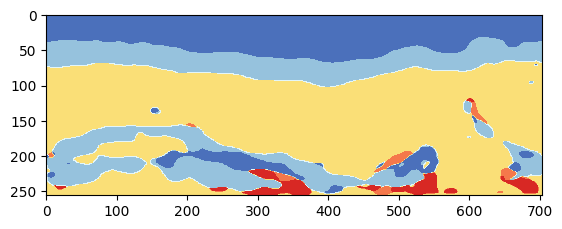

In [12]:
plt.imshow(image.squeeze().numpy(), cmap=label_cmap)
plt.show()